2024-05-23 13:35:54.349382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 13:35:54.374533: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 13:35:54.787231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-23 13:35:55.440633: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/t

Iniciando o treinamento do VAE...
Epoch 1/140


I0000 00:00:1716482157.143374  205662 service.cc:145] XLA service 0x726ef4019740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716482157.143399  205662 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-05-23 13:35:57.187090: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 13:35:57.383477: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1716482158.253531  205723 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2375', 100 bytes spill stores, 92 bytes spill loads



 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.3286

I0000 00:00:1716482160.485203  205662 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 9.3299 - val_loss: 6.6254
Epoch 2/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.1766 - val_loss: 6.5243
Epoch 3/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.5705 - val_loss: 6.4000
Epoch 4/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.1822 - val_loss: 6.2466
Epoch 5/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.8902 - val_loss: 6.0786
Epoch 6/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6627 - val_loss: 5.9024
Epoch 7/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.4625 - val_loss: 5.7204
Epoch 8/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.2935 - val_loss: 5.5328
Epoch 9/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.1326 - val_loss: 5.3484
Epoch 10/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9658 - val_loss: 5.1463
Epoch 11/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.8129 - val_loss: 4.9583
Epoch 12/140
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.6

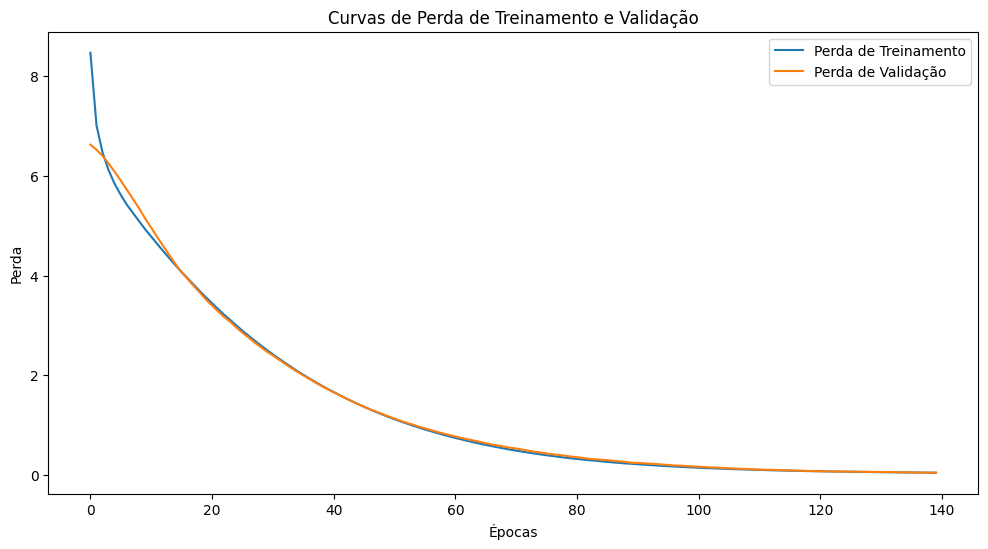

8750/8750 ━━━━━━━━━━━━━━━━━━━━ 5s 526us/step


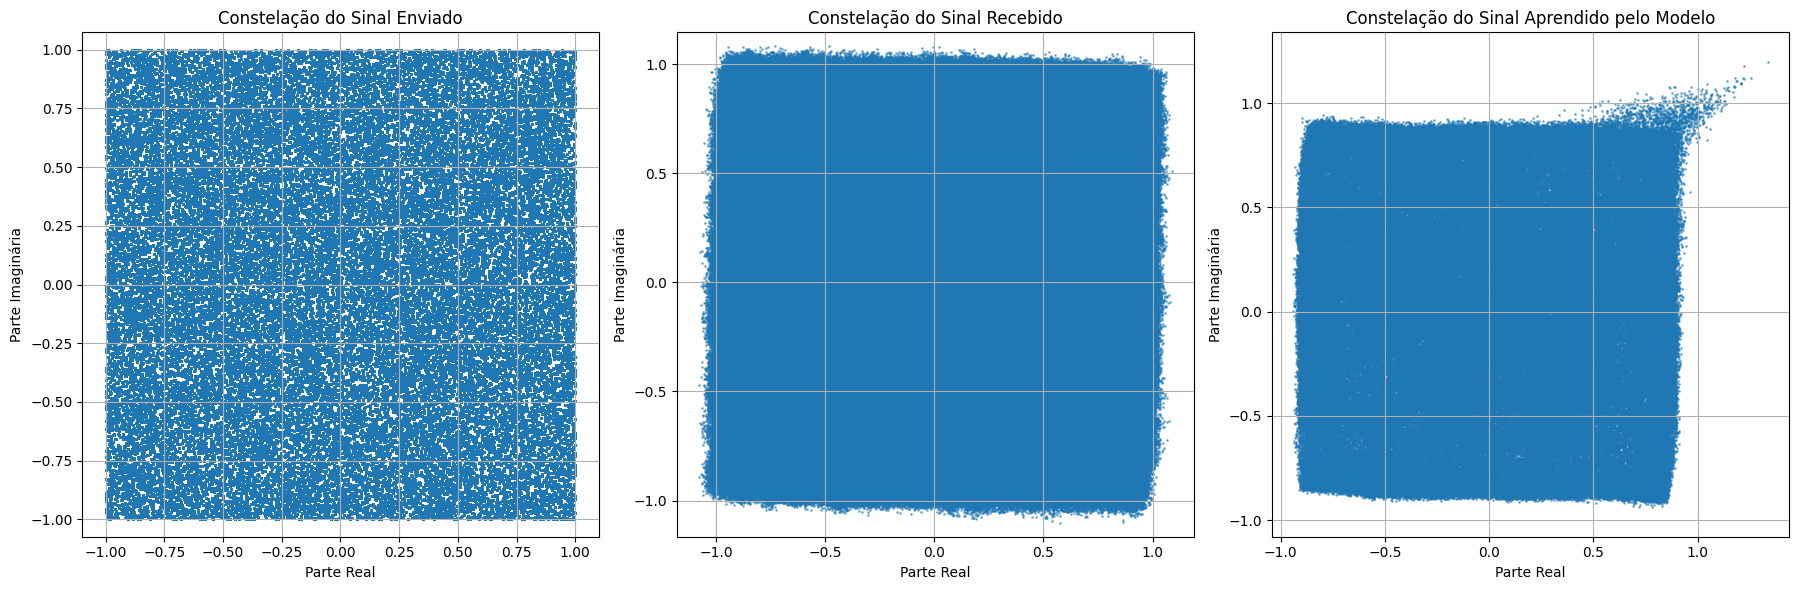

EVM entre original enviado e recebido (%): 4.325448721647263, dB: -27.279376983642578
EVM entre original enviado e aprendido (%): 10.90603917837143, dB: -19.24665927886963
43750/43750 ━━━━━━━━━━━━━━━━━━━━ 19s 440us/step
EVM entre sinais enviados reais e sinais aprendidos (%): 10.230660438537598
EVM entre sinais enviados reais e sinais aprendidos (dB): -19.801926612854004


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

# Carregar os dados
IQ_x_tuple = np.load('../sent_data_tuple.npy')
IQ_y_tuple = np.load('../received_data_tuple_sync-phase.npy')  # Normalizado e sincronizado com ajuste de fase

# Definir hiperparâmetros
latent_dim = 100
epochs = 140
batch_size = 32000
dropout_rate = 0.3
noise_std = 0.01
learning_rate = 0.0001  # Reduzir a taxa de aprendizado

# Encoder
def build_encoder(latent_dim, input_dim=2):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    model = models.Model(inputs, [z_mean, z_log_var], name='encoder')
    return model, z_mean, z_log_var

# Decoder
def build_decoder(latent_dim, output_dim=2):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(output_dim, activation='linear')(x)
    model = models.Model(latent_inputs, outputs, name='decoder')
    return model

# Função de amostragem para VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Função de perda customizada para VAE
def custom_iq_loss(y_true, y_pred):
    y_true_complex = tf.complex(y_true[:, 0], y_true[:, 1])
    y_pred_complex = tf.complex(y_pred[:, 0], y_pred[:, 1])
    error_magnitude = tf.abs(y_true_complex - y_pred_complex)
    return tf.reduce_mean(tf.square(error_magnitude))

# Montar o modelo
encoder, z_mean, z_log_var = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

# Adicionar ruído branco aos dados de entrada durante o treinamento
X_train, X_test, Y_train, Y_test = train_test_split(IQ_x_tuple, IQ_y_tuple, test_size=0.2, random_state=52)
X_train_noisy = X_train + np.random.normal(0, noise_std, X_train.shape)
X_test_noisy = X_test + np.random.normal(0, noise_std, X_test.shape)

# Compilar e treinar o VAE
vae_inputs = encoder.input
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
vae_outputs = decoder(z)
vae = models.Model(vae_inputs, vae_outputs, name='vae')
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss=custom_iq_loss)

# Treinamento do VAE
print("Iniciando o treinamento do VAE...")
history = vae.fit(X_train_noisy, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_noisy, Y_test))
print("Treinamento do VAE concluído.")

# Plotar as curvas de perda para treinamento e validação
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.title('Curvas de Perda de Treinamento e Validação')
plt.show()

# Gerar as previsões para Y a partir de X usando o modelo treinado
Y_pred = vae.predict(X_test)

# Converter Y_pred de volta para a forma complexa para calcular o EVM
Y_pred_complex = Y_pred[:, 0] + 1j * Y_pred[:, 1]

# Converter Y_test de volta para a forma complexa (caso ainda não esteja)
Y_test_complex = Y_test[:, 0] + 1j * Y_test[:, 1]

# Função para plotar constelações
def plot_constellations(IQ_x, IQ_y, Y_pred):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    def plot_constellation(data_complex, title, ax):
        data_complex = np.array(data_complex)
        ax.scatter(data_complex[:, 0], data_complex[:, 1], s=1, alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel('Parte Real')
        ax.set_ylabel('Parte Imaginária')
        ax.grid(True)
        ax.axis('equal')
        ax.set_xlim([data_complex[:, 0].min() - 0.1, data_complex[:, 0].max() + 0.1])
        ax.set_ylim([data_complex[:, 1].min() - 0.1, data_complex[:, 1].max() + 0.1])

    plot_constellation(IQ_x, "Constelação do Sinal Enviado", axs[0])
    plot_constellation(IQ_y, "Constelação do Sinal Recebido", axs[1])
    plot_constellation(Y_pred, "Constelação do Sinal Aprendido pelo Modelo", axs[2])

    plt.tight_layout()
    plt.show()

# Plotar constelações
plot_constellations(IQ_x_tuple, IQ_y_tuple, Y_pred)

# Função para calcular EVM
def calculate_evm(reference_signal, test_signal):
    reference_complex = reference_signal[:, 0] + 1j * reference_signal[:, 1]
    test_complex = test_signal[:, 0] + 1j * test_signal[:, 1]
    error_vector = test_complex - reference_complex
    error_magnitude = np.abs(error_vector)
    average_power = np.mean(np.abs(reference_complex)**2)
    EVM = np.sqrt(np.mean(error_magnitude**2) / average_power)
    EVM_percentage = EVM * 100
    EVM_dB = 20 * np.log10(EVM)
    return EVM_percentage, EVM_dB

# Calculando EVM
EVM_percentage_original, EVM_dB_original = calculate_evm(IQ_x_tuple, IQ_y_tuple)
EVM_percentage_learned, EVM_dB_learned = calculate_evm(Y_test, Y_pred)

# Mostrar resultados EVM
print(f"EVM entre original enviado e recebido (%): {EVM_percentage_original}, dB: {EVM_dB_original}")
print(f"EVM entre original enviado e aprendido (%): {EVM_percentage_learned}, dB: {EVM_dB_learned}")

# Gerar as previsões para o conjunto completo de sinais enviados
Y_pred_full = vae.predict(IQ_x_tuple)

# Converter as previsões de volta para a forma complexa
Y_pred_full_complex = Y_pred_full[:, 0] + 1j * Y_pred_full[:, 1]

# Calcular EVM entre os sinais enviados reais e os sinais aprendidos (reconstruídos pelo modelo)
EVM_percentage_full, EVM_dB_full = calculate_evm(IQ_x_tuple, Y_pred_full)

print(f"EVM entre sinais enviados reais e sinais aprendidos (%): {EVM_percentage_full}")
print(f"EVM entre sinais enviados reais e sinais aprendidos (dB): {EVM_dB_full}")
